In [253]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [254]:
import cv2
import pandas as pd
import numpy as np
import os

In [255]:
FOLDER_PATH = "dataset/"
MODEL_OUTPUT_PATH = "model/"
NUM_CLASSES = 2
TEST_SPLIT = 0.2
RANDOM_SEED = 42
IMG_SIZE = 224

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 32
NUM_WORKERS = 4
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
MODEL_NAME = 'resnet50'
NUM_EPOCHS = 20

In [256]:
labels = [item for item in os.listdir(FOLDER_PATH) if os.path.isdir(os.path.join(FOLDER_PATH, item))]
labels

['poisonous sporocarp',
 'edible sporocarp',
 'poisonous mushroom sporocarp',
 'edible mushroom sporocarp']

In [257]:
LABEL_TO_INDEX = {
	'poisonous sporocarp': 1,
	'edible sporocarp': 0,
	'poisonous mushroom sporocarp': 1,
	'edible mushroom sporocarp': 0
}

BINARY_LABELS = ['edible', 'poisonous']

In [258]:
def create_dataset(FOLDER_PATH, labels):
	data = []
	for label in labels:
		label_path = os.path.join(FOLDER_PATH, label)
		for image_file in os.listdir(label_path):
			image_path = os.path.join(label_path, image_file)
			data.append([image_path, LABEL_TO_INDEX[label]])
	data = pd.DataFrame(data, columns=['image', 'label'])
	return data

In [259]:
df = create_dataset(FOLDER_PATH, labels)
df

,image,label
0,dataset/poisonous sporocarp/nncv (915).jpg,1
1,dataset/poisonous sporocarp/nncv (62).png,1
2,dataset/poisonous sporocarp/nncv (446).jpg,1
3,dataset/poisonous sporocarp/nncv (503).jpg,1
4,dataset/poisonous sporocarp/nncv (153).jpg,1
...,...,...
3396,dataset/edible mushroom sporocarp/ce (547).jpg,0
3397,dataset/edible mushroom sporocarp/ce (402).jpg,0
3398,dataset/edible mushroom sporocarp/ce (27).jpg,0
3399,dataset/edible mushroom sporocarp/ce (681).jpg,0


In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

label
1    2220
0    1181
Name: count, dtype: int64

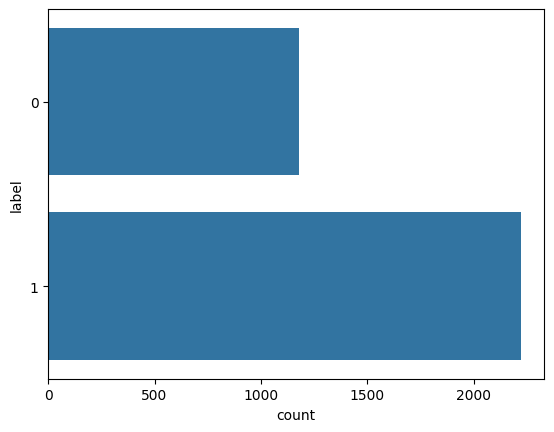

In [261]:
sns.countplot(y=df['label'])
df['label'].value_counts()

In [262]:
from sklearn.model_selection import train_test_split


In [263]:
train_df, validation_df = train_test_split(
	df,
	test_size=TEST_SPLIT,
	stratify=df['label'],
	random_state=RANDOM_SEED
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(validation_df)}")
print(train_df['label'].value_counts())
print(validation_df['label'].value_counts())

Train size: 2720
Test size: 681
label
1    1775
0     945
Name: count, dtype: int64
label
1    445
0    236
Name: count, dtype: int64


In [264]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

In [265]:
class Dataset(Dataset):
  
	def __init__(self, dataframe, img_size=IMG_SIZE, augment=False):
		self.df = dataframe.reset_index(drop=True)

		if augment:
			self.transform = transforms.Compose([
				transforms.Resize((256, 256)),
				transforms.RandomCrop(img_size),
				transforms.RandomHorizontalFlip(),
				transforms.RandomRotation(15),
				transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
				transforms.ToTensor(),
				transforms.Normalize(mean=IMAGENET_MEAN,	std=IMAGENET_STD)
			])
		else:
			self.transform = transforms.Compose([
				transforms.Resize((img_size, img_size)),
				transforms.ToTensor(),
				transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
			])
			
	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		img_path = self.df.iloc[idx]['image']
		label = self.df.iloc[idx]['label']

		image = Image.open(img_path).convert('RGB')
  
		image_transformed: torch.Tensor = self.transform(image)  # type: ignore[assignment]
  
		return image_transformed, label
		

In [266]:
test_dataset = Dataset(train_df.head(5), augment=True)
img, label = test_dataset[0]
print(f"Shape: {img.shape}")
print(f"Label: {BINARY_LABELS[label]}")
print(f"Image range: [{img.min():.3f}, {img.max():.3f}]")

Shape: torch.Size([3, 224, 224])
Label: poisonous
Image range: [-2.118, 2.640]


In [267]:
import pytorch_lightning as pl
import torch

In [268]:
class DataModule(pl.LightningDataModule):
  
  def __init__(self, train_df, validation_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS):
    super().__init__()
    self.train_df = train_df
    self.validation_df = validation_df
    self.batch_size = batch_size
    self.img_size = img_size
    self.num_workers = num_workers if torch.cuda.is_available() else 0
    
  def setup(self, stage=None):
    if stage == 'fit' or stage is None:
      self.train_dataset = Dataset(self.train_df, self.img_size, augment=True)
      self.validation_dataset = Dataset(self.validation_df, self.img_size, augment=False)

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=self.num_workers,
      pin_memory=True,
      persistent_workers=True if self.num_workers > 0 else False
    )
    
  def val_dataloader(self):
    return DataLoader(
      self.validation_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=self.num_workers,
      pin_memory=True,
      persistent_workers=True if self.num_workers > 0 else False
    )

In [269]:
from timm import create_model
import torch.nn as nn

In [270]:
class Classifier(pl.LightningModule):
  
  def __init__(self, num_classes=NUM_CLASSES, learning_rate=LEARNING_RATE, model_name=MODEL_NAME):
    super().__init__()
    self.save_hyperparameters()
    
    self.model = create_model(
      model_name,
      pretrained=True,
      num_classes=num_classes
    )
    
    self.target_layer = self.model.layer4[-1]  # type: ignore[index]
    
    self.criterion = nn.CrossEntropyLoss()
    
    self.train_accuracy = []
    self.validation_accuracy = []
    self.validation_predictions = []
    self.validation_labels = []
    
  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    images, labels = batch
    logits = self(images)
    loss = self.criterion(logits, labels)
    
    predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == labels).float().mean()
    
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    self.log('train_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True)

    return loss
  
  def validation_step(self, batch, batch_idx):
    images, labels = batch
    logits = self(images)
    loss = self.criterion(logits, labels)
    
    predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == labels).float().mean()
    
    self.validation_predictions.append(predictions)
    self.validation_labels.append(labels)

    self.log('validation_loss', loss, on_epoch=True, prog_bar=True)
    self.log('validation_accuracy', accuracy, on_epoch=True, prog_bar=True)

    return loss
  
  def on_validation_epoch_end(self):
    if len(self.validation_predictions) > 0:
      all_predictions = torch.cat(self.validation_predictions).cpu().numpy()
      all_labels = torch.cat(self.validation_labels).cpu().numpy()
      
      for i, class_name in enumerate(['edible', 'poisonous']):
        mask = all_labels == i
        if mask.sum() > 0:
          class_accuracy = (all_predictions[mask] == all_labels[mask]).mean()
          self.log(f"validation_accuracy_{class_name}", class_accuracy)

        self.validation_predictions.clear()
        self.validation_labels.clear()
        
  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(
      self.parameters(),
      lr=self.hparams.learning_rate,  # type: ignore[attr-defined]
      weight_decay=WEIGHT_DECAY
    )
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      mode='min',
      factor=0.5,
      patience=3,
    )
    
    return {
      'optimizer': optimizer,
      'lr_scheduler': {
        'scheduler': scheduler,
        'monitor': 'validation_loss',
        'interval': 'epoch',
        'frequency': 1
      }
    }

In [271]:
datamodule = DataModule(
  train_df=train_df,
  validation_df=validation_df,
)

model = Classifier()

print(f"Model created: {MODEL_NAME}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created: resnet50
Total parameters: 23,512,130
Trainable parameters: 23,512,130


In [272]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [273]:
# Callbacks Template
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    filename='fungi-{epoch:02d}-{validation_accuracy:.3f}',
    monitor='validation_accuracy',
    mode='max',
    save_top_k=3,
    save_last=True,
    verbose=True
)

early_stopping = EarlyStopping(
    monitor='validation_loss',
    patience=7,
    mode='min',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Logger
logger = TensorBoardLogger('lightning_logs', name='fungi_classifier')
print("✓ Callbacks and logger configured")

✓ Callbacks and logger configured


In [274]:
# Create Trainer Template
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator='auto',  # Automatically use GPU if available
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=logger,
    precision='16-mixed' if torch.cuda.is_available() else 32,  # Use mixed precision on GPU
    log_every_n_steps=10,
    deterministic=True,
    enable_progress_bar=True
)

print("✓ Trainer configured")
print(f"Using device: {trainer.accelerator}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


✓ Trainer configured
Using device: <pytorch_lightning.accelerators.mps.MPSAccelerator object at 0x1397c0670>


In [275]:
trainer.fit(model, datamodule)
print("done.")

/Users/hafang/Repositories/computer-vision-aol/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /Users/hafang/Repositories/computer-vision-aol/checkpoints exists and is not empty.

  | Name         | Type             | Params | Mode  | FLOPs
------------------------------------------------------------------
0 | model        | ResNet           | 23.5 M | train | 0    
1 | target_layer | Bottleneck       | 4.5 M  | train | 0    
2 | criterion    | CrossEntropyLoss | 0      | train | 0    
------------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
218       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/hafang/Repositories/computer-vision-aol/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:485: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/hafang/Repositories/computer-vision-aol/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/hafang/Repositories/computer-vision-aol/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/hafang/Repositories/computer-vision-aol/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 85/85 [01:37<00:00,  0.87it/s, v_num=16, train_loss_step=0.580, train_accuracy_step=0.750, validation_loss=0.622, validation_accuracy=0.653, train_loss_epoch=0.645, train_accuracy_epoch=0.645]

Metric validation_loss improved. New best score: 0.622
Epoch 0, global step 85: 'validation_accuracy' reached 0.65345 (best 0.65345), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=00-validation_accuracy=0.653.ckpt' as top 3


Epoch 1: 100%|██████████| 85/85 [01:38<00:00,  0.86it/s, v_num=16, train_loss_step=0.577, train_accuracy_step=0.688, validation_loss=0.576, validation_accuracy=0.687, train_loss_epoch=0.601, train_accuracy_epoch=0.656]

Metric validation_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.576
Epoch 1, global step 170: 'validation_accuracy' reached 0.68722 (best 0.68722), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=01-validation_accuracy=0.687.ckpt' as top 3


Epoch 2: 100%|██████████| 85/85 [01:43<00:00,  0.82it/s, v_num=16, train_loss_step=0.531, train_accuracy_step=0.812, validation_loss=0.525, validation_accuracy=0.733, train_loss_epoch=0.562, train_accuracy_epoch=0.688]

Metric validation_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.525
Epoch 2, global step 255: 'validation_accuracy' reached 0.73275 (best 0.73275), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=02-validation_accuracy=0.733.ckpt' as top 3


Epoch 3: 100%|██████████| 85/85 [01:42<00:00,  0.83it/s, v_num=16, train_loss_step=0.554, train_accuracy_step=0.625, validation_loss=0.474, validation_accuracy=0.767, train_loss_epoch=0.504, train_accuracy_epoch=0.735]

Metric validation_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.474
Epoch 3, global step 340: 'validation_accuracy' reached 0.76652 (best 0.76652), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=03-validation_accuracy=0.767.ckpt' as top 3


Epoch 4: 100%|██████████| 85/85 [01:46<00:00,  0.80it/s, v_num=16, train_loss_step=0.412, train_accuracy_step=0.812, validation_loss=0.426, validation_accuracy=0.797, train_loss_epoch=0.450, train_accuracy_epoch=0.780]

Metric validation_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.426
Epoch 4, global step 425: 'validation_accuracy' reached 0.79736 (best 0.79736), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=04-validation_accuracy=0.797.ckpt' as top 3


Epoch 5: 100%|██████████| 85/85 [01:41<00:00,  0.83it/s, v_num=16, train_loss_step=0.393, train_accuracy_step=0.844, validation_loss=0.409, validation_accuracy=0.816, train_loss_epoch=0.393, train_accuracy_epoch=0.822]

Metric validation_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.409
Epoch 5, global step 510: 'validation_accuracy' reached 0.81645 (best 0.81645), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=05-validation_accuracy=0.816.ckpt' as top 3


Epoch 6: 100%|██████████| 85/85 [01:43<00:00,  0.82it/s, v_num=16, train_loss_step=0.240, train_accuracy_step=0.906, validation_loss=0.387, validation_accuracy=0.836, train_loss_epoch=0.331, train_accuracy_epoch=0.855]

Metric validation_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.387
Epoch 6, global step 595: 'validation_accuracy' reached 0.83554 (best 0.83554), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=06-validation_accuracy=0.836.ckpt' as top 3


Epoch 7: 100%|██████████| 85/85 [01:44<00:00,  0.81it/s, v_num=16, train_loss_step=0.294, train_accuracy_step=0.906, validation_loss=0.366, validation_accuracy=0.841, train_loss_epoch=0.289, train_accuracy_epoch=0.876]

Metric validation_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.366
Epoch 7, global step 680: 'validation_accuracy' reached 0.84141 (best 0.84141), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=07-validation_accuracy=0.841.ckpt' as top 3


Epoch 8: 100%|██████████| 85/85 [01:44<00:00,  0.81it/s, v_num=16, train_loss_step=0.107, train_accuracy_step=1.000, validation_loss=0.354, validation_accuracy=0.855, train_loss_epoch=0.246, train_accuracy_epoch=0.901]

Metric validation_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.354
Epoch 8, global step 765: 'validation_accuracy' reached 0.85463 (best 0.85463), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=08-validation_accuracy=0.855.ckpt' as top 3


Epoch 9: 100%|██████████| 85/85 [01:45<00:00,  0.81it/s, v_num=16, train_loss_step=0.222, train_accuracy_step=0.875, validation_loss=0.340, validation_accuracy=0.862, train_loss_epoch=0.203, train_accuracy_epoch=0.923] 

Metric validation_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.340
Epoch 9, global step 850: 'validation_accuracy' reached 0.86197 (best 0.86197), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=09-validation_accuracy=0.862.ckpt' as top 3


Epoch 10: 100%|██████████| 85/85 [01:47<00:00,  0.79it/s, v_num=16, train_loss_step=0.186, train_accuracy_step=0.844, validation_loss=0.361, validation_accuracy=0.858, train_loss_epoch=0.168, train_accuracy_epoch=0.935] 

Epoch 10, global step 935: 'validation_accuracy' reached 0.85756 (best 0.86197), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=10-validation_accuracy=0.858.ckpt' as top 3


Epoch 11: 100%|██████████| 85/85 [01:47<00:00,  0.79it/s, v_num=16, train_loss_step=0.190, train_accuracy_step=0.938, validation_loss=0.367, validation_accuracy=0.866, train_loss_epoch=0.137, train_accuracy_epoch=0.949] 

Epoch 11, global step 1020: 'validation_accuracy' reached 0.86637 (best 0.86637), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=11-validation_accuracy=0.866.ckpt' as top 3


Epoch 12: 100%|██████████| 85/85 [01:59<00:00,  0.71it/s, v_num=16, train_loss_step=0.120, train_accuracy_step=0.938, validation_loss=0.382, validation_accuracy=0.869, train_loss_epoch=0.117, train_accuracy_epoch=0.957] 

Epoch 12, global step 1105: 'validation_accuracy' reached 0.86931 (best 0.86931), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=12-validation_accuracy=0.869.ckpt' as top 3


Epoch 13: 100%|██████████| 85/85 [02:50<00:00,  0.50it/s, v_num=16, train_loss_step=0.0866, train_accuracy_step=1.000, validation_loss=0.415, validation_accuracy=0.874, train_loss_epoch=0.104, train_accuracy_epoch=0.964]

Epoch 13, global step 1190: 'validation_accuracy' reached 0.87372 (best 0.87372), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=13-validation_accuracy=0.874.ckpt' as top 3


Epoch 14: 100%|██████████| 85/85 [02:17<00:00,  0.62it/s, v_num=16, train_loss_step=0.104, train_accuracy_step=0.969, validation_loss=0.379, validation_accuracy=0.874, train_loss_epoch=0.0914, train_accuracy_epoch=0.966]

Epoch 14, global step 1275: 'validation_accuracy' reached 0.87372 (best 0.87372), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=14-validation_accuracy=0.874.ckpt' as top 3


Epoch 15: 100%|██████████| 85/85 [02:17<00:00,  0.62it/s, v_num=16, train_loss_step=0.0374, train_accuracy_step=1.000, validation_loss=0.388, validation_accuracy=0.869, train_loss_epoch=0.0757, train_accuracy_epoch=0.971]

Epoch 15, global step 1360: 'validation_accuracy' was not in top 3


Epoch 16: 100%|██████████| 85/85 [02:23<00:00,  0.59it/s, v_num=16, train_loss_step=0.0599, train_accuracy_step=0.969, validation_loss=0.422, validation_accuracy=0.874, train_loss_epoch=0.0726, train_accuracy_epoch=0.976]

Monitored metric validation_loss did not improve in the last 7 records. Best score: 0.340. Signaling Trainer to stop.
Epoch 16, global step 1445: 'validation_accuracy' reached 0.87372 (best 0.87372), saving model to '/Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=16-validation_accuracy=0.874.ckpt' as top 3


Epoch 16: 100%|██████████| 85/85 [02:24<00:00,  0.59it/s, v_num=16, train_loss_step=0.0599, train_accuracy_step=0.969, validation_loss=0.422, validation_accuracy=0.874, train_loss_epoch=0.0726, train_accuracy_epoch=0.976]
done.


In [276]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model checkpoint: {best_model_path}")
print(f"Best validation accuracy: {checkpoint_callback.best_model_score:.4f}")

best_model = Classifier.load_from_checkpoint(best_model_path)
best_model.eval()

torch.save({
    'model_state_dict': best_model.model.state_dict(),
    'model_name': 'resnet50',
    'num_classes': NUM_CLASSES,
    'validation_accuracy': checkpoint_callback.best_model_score.item(),  # type: ignore[union-attr]
    'img_size': IMG_SIZE,
    'class_names': BINARY_LABELS,
    'FOLDER_PATH': MODEL_OUTPUT_PATH
}, 'best_fungi_model.pt')

Best model checkpoint: /Users/hafang/Repositories/computer-vision-aol/checkpoints/fungi-epoch=13-validation_accuracy=0.874.ckpt
Best validation accuracy: 0.8737


In [277]:
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

In [278]:
# Evaluation Template
best_model.eval()
datamodule.setup('fit')

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(datamodule.val_dataloader(), desc='Evaluating'):
        images, labels = batch
        images = images.to(best_model.device)
        
        logits = best_model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=BINARY_LABELS, digits=4))

/Users/hafang/Repositories/computer-vision-aol/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 22/22 [00:10<00:00,  2.04it/s]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      edible     0.8827    0.7331    0.8009       236
   poisonous     0.8701    0.9483    0.9075       445

    accuracy                         0.8737       681
   macro avg     0.8764    0.8407    0.8542       681
weighted avg     0.8745    0.8737    0.8706       681



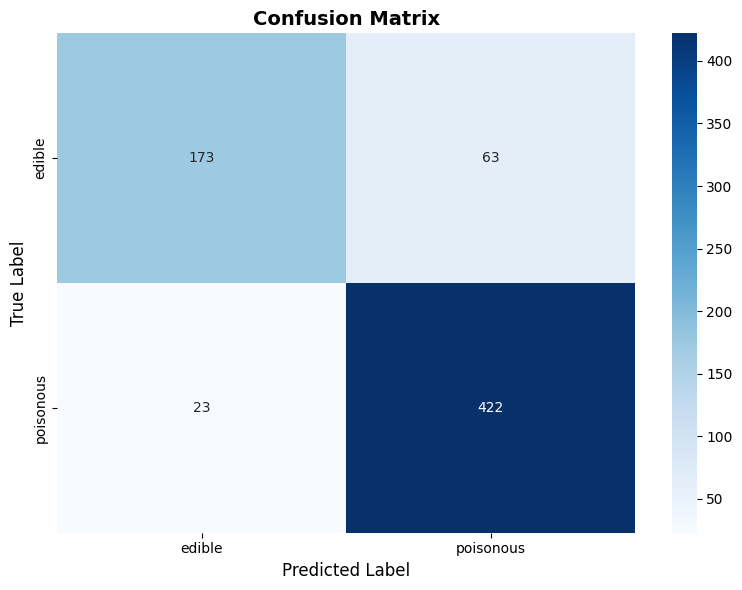

In [280]:
# Confusion Matrix Template

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=BINARY_LABELS, yticklabels=BINARY_LABELS)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
# plt.savefig('confusion_mat
# rix.png', dpi=150, bbox_inches='tight')
plt.show()

# print("✓ Confusion matrix saved as 'confusion_matrix.png'")